In [2]:
import networkx

#Create Graph
def generateItemGraph(graphNumber):
    itemGraph = networkx.MultiDiGraph()
    itemGraph.add_node('Item' + str(graphNumber), value = '')
    itemGraph.add_node('ItemName' + str(graphNumber), value = '')
    itemGraph.add_node('ItemAffordance' + str(graphNumber), value = '')
    itemGraph.add_node('ItemDescription' + str(graphNumber), value = '')
    itemGraph.add_node('ItemRole' + str(graphNumber), value = '')

    itemGraph.add_edge('Item' + str(graphNumber), 'ItemName' + str(graphNumber), value = 'ItemHasName')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemAffordance' + str(graphNumber), value = 'ItemHasAffordance')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemDescription' + str(graphNumber), value = 'ItemHasDescription')
    itemGraph.add_edge('Item' + str(graphNumber), 'ItemRole' + str(graphNumber), value = 'ItemHasRole')

    return itemGraph

def generatePropGraph(graphNumber):
    propGraph = networkx.MultiDiGraph()
    propGraph.add_node('Property' + str(graphNumber), value = '')
    propGraph.add_node('PropertyAdjective' + str(graphNumber), value = '')
    propGraph.add_node('PropertySecondaryObject' + str(graphNumber), value = '')
    propGraph.add_node('PropertyTertiaryObject' + str(graphNumber), value = '')
    propGraph.add_node('PropertyDegree' + str(graphNumber), value = '')
    propGraph.add_node('PropertyCompTarget' + str(graphNumber), value = '')

    propGraph.add_edge('Property' + str(graphNumber), 'PropertyAdjective' + str(graphNumber), value = 'PropertyHasAdjective')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertySecondaryObject' + str(graphNumber), value = 'PropertyHasSecondaryObject')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyTertiaryObject' + str(graphNumber), value = 'PropertyHasTertiaryObject')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyDegree' + str(graphNumber), value = 'PropertyHasDegree')
    propGraph.add_edge('Property' + str(graphNumber), 'PropertyCompTarget' + str(graphNumber), value = 'PropertyHasCompTarget')

    return propGraph

def generateActionGraph(graphNumber):
    actionGraph = networkx.MultiDiGraph()
    actionGraph.add_node('Action' + str(graphNumber), value = '')
    actionGraph.add_node('ActionVerb' + str(graphNumber), value = '')
    
    actionGraph.add_edge('Action' + str(graphNumber), 'ActionVerb' + str(graphNumber), value = 'ActionHasVerb')
    
    return actionGraph

def generateModPPGraph(graphNumber):
    modPPGraph = networkx.MultiDiGraph()
    modPPGraph.add_node('ModPP' + str(graphNumber), value = '')
    modPPGraph.add_node('ModPPPrep' + str(graphNumber), value = '')
    
    modPPGraph.add_edge('ModPP' + str(graphNumber), 'ModPPPrep' + str(graphNumber), value = 'ModPPHasPrep')
    
    return modPPGraph

In [3]:
class ItemGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateItemGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Item Graph
    def appendItemValue(self, newValue):
        self.__append('Item', newValue)
        
    def replaceItemValue(self, newValue):
        self.__replace('Item', newValue)
                
    def appendItemName(self, newName):
        self.__append('ItemName', newName)
        
    def replaceItemName(self, newName):
        self.__replace('ItemName', newName)
        
    def appendItemAffordance(self, newAffordance):
        self.__append('ItemAffordance', newAffordance)
    
    def replaceItemAffordance(self, newAffordance):
        self.__replace('ItemAffordance', newAffordance)
    
    def appendItemDescription(self, newDescription):
        self.__append('ItemDescription', newDescription)
    
    def replaceItemDescription(self, newDescription):
        self.__replace('ItemDescription', newDescription)
    
    def appendItemRole(self, newRole):
        self.__append('ItemRole', newRole)
    
    def replaceItemRole(self, newRole):
        self.__replace('ItemRole', newRole)
    
    #Method to get the type of graph    
    #def getTypeOfNode(self, node):
    #    print(node)
    #    print(self.graph.nodes[node])
    #    return self.graph.nodes[node]['value']
        
    #Method to find a node containing a given value
    def FindItemWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None
    
    #Methods to add different types of edges between nodes
    def addGroupMembershipEdges(self, groupNode, memberNode):
        self.graph.add_edge(memberNode, groupNode, value='IsMemberOf')
        self.graph.add_edge(groupNode, memberNode, value='HasMember')
        
    def addNodeEquivalencyEdges(self, firstNode, secondNode):
        self.graph.add_edge(firstNode, secondNode, value='IsEquivalentTo')
        self.graph.add_edge(secondNode, firstNode, value='IsEquivalentTo')
        
    def addCompositionEdges(self, composedNode, partOfNode):
        self.graph.add_edge(composedNode, partOfNode, value='HasA')
        self.graph.add_edge(partOfNode, composedNode, value='IsPartOf')
          
    def addPropertyEdge(self, objectNode, propertyNode):
        self.graph.add_edge(objectNode, propertyNode, value='Is')
    
   #Methods to add different types of edges between nodes
    def addActionPerformerEdges(self, performerNode, actionNode):
        self.graph.add_edge(performerNode, actionNode, value='Performs')
        self.graph.add_edge(actionNode, performerNode, value='IsPerformedBy')
        
    def addActionTargetEdges(self, actionNode, targetNode):
        self.graph.add_edge(actionNode, targetNode, value='HasTarget')
        self.graph.add_edge(targetNode, actionNode, value='IsTargetOf')
        
    def addModifierVerbEdges(self, modifierNode, verbNode):
        self.graph.add_edge(modifierNode, verbNode, value='ModifiesVerb')
        self.graph.add_edge(verbNode, modifierNode, value='isModifiedBy')
        
    def addModifierObjectEdges(self, modifierNode, objectNode):
        self.graph.add_edge(modifierNode, objectNode, value='modifiesObject')
        self.graph.add_edge(objectNode, modifierNode, value='isModifiedBy')
        
    #Methods to replace values of specific nodes
    def ReplaceItemAffordanceAtSpecificNode(self, nodeToAddAffordance, newAffordance):
        node = self.FindItemWithValue(nodeToAddAffordance)
        if(node != None):
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasAffordance'):
                    #Update graph with name
                    self.graph.nodes(data=True)[endNode]['value'] = newAffordance
                    return True
        else:
            print("No node with direct object reference as value found")
            return False
        
    #Methods to replace values of specific nodes
    def AppendItemAffordanceAtSpecificNode(self, nodeToAddAffordance, newAffordance):
        node = self.FindItemWithValue(nodeToAddAffordance)
        if(node != None):
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasAffordance'):
                    #Update graph with name
                    currentValue = self.graph.nodes(data=True)[endNode]['value']
                    if(currentValue == ''):
                        updatedValue = newAffordance
                    else:
                        updatedValue = currentValue + '|' + newAffordance
                    self.graph.nodes(data=True)[endNode]['value'] = updatedValue
                    return True
        else:
            print("No node with direct object reference as value found")
            return False


    def ReplaceItemNameAtSpecificNode(self, nodeToAddName, newName):
        #Find Node
        node = self.FindItemWithValue(nodeToAddName)
        if(node != None):
            #Get list of edges from the node
            edgesFromNode = self.graph.edges(node, data=True)
            for startNode, endNode, edgeValues in edgesFromNode:
                #If an edge has the value ItemHasName, then we want to modify the end node
                if(edgeValues['value'] == 'ItemHasName'):
                    #Update graph with name
                    self.graph.nodes(data=True)[endNode]['value'] = newName
                    return True
        else:
            print("No node with direct object reference as value found")
            return False

In [4]:
class PropertyGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generatePropGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendPropValue(self, newValue):
        self.__append('Property', newValue)
        
    def replacePropValue(self, newValue):
        self.__replace('Property', newValue)
                
    def appendPropAdj(self, newAdjective):
        self.__append('PropertyAdjective', newAdjective)
        
    def replacePropAdj(self, newValue):
        self.__replace('PropertyAdjective', newAdjective)
        
    def appendPropSecObj(self, newSecondaryObject):
        self.__append('PropertySecondaryObject', newSecondaryObject)
        
    def replacePropSecObj(self, newSecondaryObject):
        self.__replace('PropertySecondaryObject', newSecondaryObject)
        
    def appendPropTertObj(self, newTertiaryObject):
        self.__append('PropertyTertiaryObject', newTertiaryObject)
        
    def replacePropTertObj(self, newTertiaryObject):
        self.__replace('PropertyTertiaryObject', newTertiaryObject)
        
    def appendPropDegree(self, newDegree):
        self.__append('PropertyDegree', newDegree)
        
    def replacePropDegree(self, newDegree):
        self.__replace('PropertyDegree', newDegree)
        
    def appendPropCompTarget(self, newCompTarget):
        self.__append('PropertyCompTarget', newCompTarget)
        
    def replacePropCompTarget(self, newCompTarget):
        self.__replace('PropertyCompTarget', newCompTarget)
            
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindPropertyWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [5]:
class ActionGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateActionGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendActionValue(self, newValue):
        self.__append('Action', newValue)
        
    def replaceActionValue(self, newValue):
        self.__replace('Action', newValue)
                
    def appendActionVerb(self, newVerb):
        self.__append('ActionVerb', newVerb)
        
    def replaceActionVerb(self, newValue):
        self.__replace('ActionVerb', newVerb)
        
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindActionWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [6]:
#Modifier_PP (adv will need a different graph)
class ModifierPPGraph(object):
    #Constructor
    def __init__(self, graphNumber):
        self.graphNumber = graphNumber
        if(graphNumber != None):
            self.graph = generateModPPGraph(self.graphNumber)
        else:
            self.graph = None
        
    #Generic append method based on whatever target is passed in    
    def __append(self, target, newValue):
        currentValue = self.graph.nodes(data=True)[target + str(self.graphNumber)]['value']
        if(currentValue == ''):
            updatedValue = newValue
        else:
            updatedValue = currentValue + '|' + newValue
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = updatedValue
    
    #Generic replace method based on whatever target is passed in
    def __replace(self, target, newValue):
        self.graph.nodes(data=True)[target + str(self.graphNumber)]['value'] = newValue

    #Append/replace methods for each node value in Property Graph
    def appendModPPValue(self, newValue):
        self.__append('ModPP', newValue)
        
    def replaceModPPValue(self, newValue):
        self.__replace('ModPP', newValue)
                
    def appendModPPPrep(self, newPreposition):
        self.__append('ModPPPrep', newPreposition)
        
    def replaceModPPPrep(self, newPreposition):
        self.__replace('ModPPPrep', newPreposition)
    
    #Method to get the type of graph    
    ##def getTypeOfNode(self, node):
    #    return self.graph.nodes[node]['value']
    
    #Method to find a node containing a given value
    def FindModWithValue(self, valueToFind):
        if(self.graph != None):
            #iterate through all graph nodes
            for node, values in self.graph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    return node
        return None

In [7]:
class predicateSwitcher(object):
    
    def __init__(self):
        self.graphNumber = 0
        self.DRSGraph = ItemGraph(None)
        
    #Method to call the appropriate function based on the argument passed in
    def callFunction(self, predicateType, predicateContents):
        #Get the name of the method
        methodName = 'predicate_' + str(predicateType)
        #Get the method itself
        method = getattr(self, methodName, lambda: "Unknown predicate")
        #Call the method and return its output
        method(predicateContents)
        return self.DRSGraph
        
    #For object() predicates
    #SHOULD CHECK IF OBJECT WITH GIVEN NAME ALREADY EXISTS!!!  IF SO, FIGURE OUT WHAT ARE THE CONDITIONS FOR THAT TO OCCUR
    def predicate_object(self, predicateContents):
        print(predicateContents)
        #Break up elements of object line into variables
        predicateComponents = predicateContents.split(',')
        objReferenceVariable = predicateComponents[0]
        objName = predicateComponents[1]
        objClass = predicateComponents[2]
        objUnit = predicateComponents[3]
        objOperator = predicateComponents[4]
        objCount = predicateComponents[5].split(')')[0]
        if(self.DRSGraph.FindItemWithValue(objReferenceVariable) == None):
            #Apply appropriate variables to ItemGraph
            objectGraph = ItemGraph(self.graphNumber)
            objectGraph.appendItemValue(objReferenceVariable)
            objectGraph.appendItemRole(objName)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                #DRSGraph.graph = networkx.algorithms.operators.binary.union(DRSGraph.graph, objectGraph.graph)
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, objectGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = objectGraph.graph
            return True
        else:
            return False
    
    #For predicate() predicates
    #HOW TO HANDLE SENTENCE SUB-ORDINATION?
    def predicate_predicate(self, predicateContents):
        #Intransitive verbs: (predName, verb, subjectRef) 
        #- The SubjectRef Verbed (the man laughed, the target appears)
        #Transitive verbs: (predName, verb, subjectRef, dirObjRef)
        #- The Subjectref Verbed the dirObjRef (the task A has a group of objects H, the subject L remembers the letter I)
        #Ditransitive verbs: (predName, verb, subjRef, dirObjRef, indirObjRef)
        #- The SubjectRef verbed the DirObjRef to the indirObjRef (The professor (S) gave the paper (D) to the student (I))
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first three components, so only special cases are transitive/ditransitive
        predReferenceVariable = predicateComponents[0]
        predVerb = predicateComponents[1]
        predSubjRef = predicateComponents[2]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #intransitive
            predSubjRef = predSubjRef.split(')')[0]
        elif(numberOfComponents == 4):
            #Transitive
            predDirObjRef = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 5):
            #Ditransitive
            predIndirObjRef = predicateComponents[4].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        #Hardcode be case for specific scenarios
        
        if(predVerb == 'be'):
            #Check if naming or setting an equivalency
            if('named' in predSubjRef):
                #If so call naming method
                self.DRSGraph = nameItem(predSubjRef, predDirObjRef, self.DRSGraph)
            #If not named(XYZ) but still has 4 components
            elif(numberOfComponents == 4):
                #Get nodes for both subject and direct object
                subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                #If both are ITEM nodes in the graph, then the "Be" is setting an equivalency
                if(subjRefNode != None and dirObjRefNode != None and 'Item' in dirObjRefNode):
                    self.DRSGraph.addNodeEquivalencyEdges(subjRefNode, dirObjRefNode)
                #If the target node is a PROPERTY node, then the 'BE' is setting an "is" property relationship
                elif(subjRefNode != None and dirObjRefNode != None and 'Property' in dirObjRefNode):
                    self.DRSGraph.addPropertyEdge(subjRefNode, dirObjRefNode)
            #HANDLE ANY OTHER CASES????
            
        #Hardcode "have" case for composition
        elif(predVerb == 'have'):
            if(numberOfComponents == 4):
                #Get nodes for both subject and direct object
                subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                #If both are nodes in the graph, then the "have" is setting a composition
                if(subjRefNode != None and dirObjRefNode != None):
                    self.DRSGraph.addCompositionEdges(subjRefNode, dirObjRefNode)
        else:
            #Create Action Node
            self.DRSGraph.AppendItemAffordanceAtSpecificNode(predSubjRef, predVerb)
            actionGraph = ActionGraph(self.graphNumber)
            actionGraph.appendActionValue(predReferenceVariable)
            actionGraph.appendActionVerb(predVerb)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, actionGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = actionGraph.graph
            
            #Get subject reference node
            subjRefNode = self.DRSGraph.FindItemWithValue(predSubjRef)
            actionNode = self.DRSGraph.FindItemWithValue(predReferenceVariable)
            
            #If just one subject "The target appears"
            if(numberOfComponents == 3):
                #self.DRSGraph.AppendItemAffordanceAtSpecificNode(predSubjRef, predVerb)
                self.DRSGraph.addActionPerformerEdges(subjRefNode, actionNode)
            #If subject and direct object (e.g. "The subject remembers the letter")
            #predSubjRef = "Subject", predDirObjRef = "letter"
            elif(numberOfComponents == 4):
                dirObjRefNode = self.DRSGraph.FindItemWithValue(predDirObjRef)
                self.DRSGraph.addActionPerformerEdges(subjRefNode, actionNode)
                self.DRSGraph.addActionTargetEdges(actionNode, dirObjRefNode)
                
            #TODO TODO TODO TODO
            elif(numberOfComponents == 5):
                pass
    
    #For has_part() predicates
    def predicate_has_part(self, predicateContents):
        #Get predicate items
        predicateComponents = predicateContents.split(',')
        predGroupRef = predicateComponents[0]
        predGroupMember = predicateComponents[1].split(')')[0]
        #Hardcode the new object as being a group
        predGroupDescription = 'GROUP'
        #if Group reference doesn't exist
        groupNode = self.DRSGraph.FindItemWithValue(predGroupRef)
        memberNode = self.DRSGraph.FindItemWithValue(predGroupMember)
        if(groupNode == None):
             #Then create that item
             #Apply appropriate variables to ItemGraph
            groupGraph = ItemGraph(self.graphNumber)
            groupGraph.appendItemValue(predGroupRef)
            groupGraph.appendItemRole(predGroupDescription)
            #Get the node for the group
            groupNode = groupGraph.FindItemWithValue(predGroupRef)
            #Increase the graph number for auto-name generation
            self.graphNumber = self.graphNumber + 1
            #Compose the new graph with the existing graph 
            #(no scenario of no existing graph because can't start with has_part())
            self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, groupGraph.graph)
        #Add membership edges
        self.DRSGraph.addGroupMembershipEdges(groupNode, memberNode)
    
    #HANDLE MODIFIERS - PREPOSITION
    #TODO TODO TODO TODO
    def predicate_modifier_pp(self, predicateContents):
        #Find action node of predicate
        #Get predicate items
        predicateComponents = predicateContents.split(',')
        modPPRefID = predicateComponents[0] + 'mod'
        modPPPrep = predicateComponents[1]
        modPPModifiedVerb = predicateComponents[0]
        modPPTargetObj = predicateComponents[2].split(')')[0]
        
        #Create Modifier Node
        modGraph = ModifierPPGraph(self.graphNumber)
        modGraph.appendModPPValue(modPPRefID)
        modGraph.appendModPPPrep(modPPPrep)
        
        #Increase the graph number for auto-generation of names
        self.graphNumber = self.graphNumber + 1
        
        #If a main graph already exists, then add the new graph in to it
        if(self.DRSGraph.graph != None):
            self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, modGraph.graph)
        #if no main graph exists, this is the main graph
        else:
            self.DRSGraph.graph = modGraph.graph
            
        #Add verb and object modifier edges
        modNode = self.DRSGraph.FindItemWithValue(modPPRefID)
        verbNode = self.DRSGraph.FindItemWithValue(modPPModifiedVerb)
        objectNode = self.DRSGraph.FindItemWithValue(modPPTargetObj)
        self.DRSGraph.addModifierVerbEdges(modNode, verbNode)
        self.DRSGraph.addModifierObjectEdges(modNode, objectNode)
            
    #HANDLE MODIFIERS - ADVERB
    def predicate_modifier_adv(self, predicateContents):
        pass
    
    #HANDLE PROPERTIES
    #TODO: Handle 4/6 component properties
    #TODO: Handle degrees besides "pos"
    def predicate_property(self, predicateContents):
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first two components, others distributed based on number of components
        propRefId = predicateComponents[0]
        propAdjective = predicateComponents[1]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #Only a primary object
            propDegree = predicateComponents[2].split(')')[0]
        elif(numberOfComponents == 4):
            #Primary and secondary object
            propDegree = predicateComponents[2]
            propSecObj = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 6):
            #Primary, secondary, and tertiary objects
            propSecObj = predicateComponents[2]
            propDegree = predicateComponents[3]
            propCompTarget = predicateComponents[4]
            propTertObj = predicateComponents[5].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
            
        if(self.DRSGraph.FindItemWithValue(propRefId) == None):
            #Apply appropriate variables to PropertyGraph (operating off same graph number
            #because the number in the name is irrelevant)
            propGraph = PropertyGraph(self.graphNumber)
            propGraph.appendPropValue(propRefId)
            propGraph.appendPropAdj(propAdjective)
            propGraph.appendPropDegree(propDegree)
            #Increase the graph number for auto-generation of names
            self.graphNumber = self.graphNumber + 1
            #If a main graph already exists, then add the new graph in to it
            if(self.DRSGraph.graph != None):
                self.DRSGraph.graph = networkx.algorithms.operators.binary.compose(self.DRSGraph.graph, propGraph.graph)
            #if no main graph exists, this is the main graph
            else:
                self.DRSGraph.graph = propGraph.graph
            return True
        else:
            return False

In [47]:
#VERY INITIAL VERSION, MOST CODE COPIED FROM PREDICATESWITCHER
#Proof of concept class to test with single case: "Is Psychomotor-Vigilance active?"
#CURRENTLY OPERATING UNDER ASSUMPTION THAT questions ALWAYS end with the predicate as the final piece.  This will 100% need revised (probably just check if 
#the current line is the final question line and then process the complete question at that point).
class questionSwitcher(object):
    
    def __init__(self):
        self.graphNumber = 0
        self.DRSGraph = None
        self.nodesWithGivenProperty = []
        self.nodesWithGivenName = []
        
    #Method to call the appropriate function based on the argument passed in
    def callFunction(self, predicateType, predicateContents, DRSGraph):
        #Get the name of the method
        methodName = 'question_' + str(predicateType)
        #Get the method itself
        method = getattr(self, methodName, lambda: "Unknown predicate")
        #Call the method and return its output
        self.DRSGraph = DRSGraph
        method(predicateContents)
        
    #HANDLE PROPERTIES
    #TODO: Handle 4/6 component properties
    #TODO: Handle degrees besides "pos"
    def question_property(self, predicateContents):
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first two components, others distributed based on number of components
        propRefId = predicateComponents[0]
        propAdjective = predicateComponents[1]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #Only a primary object
            propDegree = predicateComponents[2].split(')')[0]
        elif(numberOfComponents == 4):
            #Primary and secondary object
            propDegree = predicateComponents[2]
            propSecObj = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 6):
            #Primary, secondary, and tertiary objects
            propSecObj = predicateComponents[2]
            propDegree = predicateComponents[3]
            propCompTarget = predicateComponents[4]
            propTertObj = predicateComponents[5].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        
        #INITIAL NYM TESTING - will need to extend to other predicates as well of course
        adjectiveNymList = getNyms(propAdjective)
        adjectiveNodes = self.ListOfNodesWithValueFromList(adjectiveNymList)
        if(adjectiveNodes == None):
            #No nodes "active"
            pass
        else:
            propertyNodesWithAdjective = []
            for node in adjectiveNodes:
                #print("Node", node)
                propertyNode = self.getPropertyNodeFromAdjective(node)
                #print("propertyNode", propertyNode)
                self.nodesWithGivenProperty.append(propertyNode)
        
        
    #For predicate() predicates
    #HOW TO HANDLE SENTENCE SUB-ORDINATION?
    def question_predicate(self, predicateContents):
        #Intransitive verbs: (predName, verb, subjectRef) 
        #- The SubjectRef Verbed (the man laughed, the target appears)
        #Transitive verbs: (predName, verb, subjectRef, dirObjRef)
        #- The Subjectref Verbed the dirObjRef (the task A has a group of objects H, the subject L remembers the letter I)
        #Ditransitive verbs: (predName, verb, subjRef, dirObjRef, indirObjRef)
        #- The SubjectRef verbed the DirObjRef to the indirObjRef (The professor (S) gave the paper (D) to the student (I))
        #Break up the predicate
        predicateComponents = predicateContents.split(',')
        numberOfComponents = len(predicateComponents)
        #Always have first three components, so only special cases are transitive/ditransitive
        predReferenceVariable = predicateComponents[0]
        predVerb = predicateComponents[1]
        predSubjRef = predicateComponents[2]
        #Different cases (differing number of components)
        if(numberOfComponents == 3):
            #intransitive
            predSubjRef = predSubjRef.split(')')[0]
        elif(numberOfComponents == 4):
            #Transitive
            predDirObjRef = predicateComponents[3].split(')')[0]
        elif(numberOfComponents == 5):
            #Ditransitive
            predIndirObjRef = predicateComponents[4].split(')')[0]
        else:
            #invalid
            raise ValueError('Too many components ?')
        #Hardcode be case for specific scenarios
        
        if(predVerb == 'be'):
            #Check if find a node containing said name
            if('named' in predSubjRef):
                #Get item name out of "named(XYZ)"
                itemNodeList = []
                itemName = predSubjRef[predSubjRef.find("(")+1:predSubjRef.find(")")]
                #print(itemName)
                self.nodesWithGivenName = self.ListOfNodesWithValue(itemName)
                #print(self.nodesWithGivenName)
                #get list of item nodes which are connected to each of these names.
                #print(nameNodeList)
                #for node in nameNodeList:
                #    itemNode = self.getItemNodeFromName(node)
                #    self.nodesWithGivenName.append(itemNode)
            
    def resolveQuestion(self):
        for node in self.nodesWithGivenName:
            outEdgesFromNode = (self.DRSGraph.out_edges(node, data=True))
            inEdgesFromNode = (self.DRSGraph.in_edges(node, data=True))
            edgesFromNode = list(outEdgesFromNode) + list(inEdgesFromNode)
            #print(edgesFromNode)
            for startNode, endNode, edgeValues in edgesFromNode:
                print(startNode, endNode, edgeValues)
                if(edgeValues['value'] == 'ItemHasName'):
                    if(startNode != node):
                        nodeToConnect = startNode
                        #print(nodeToConnect)
                    elif(endNode != node):
                        nodeToConnect = endNode
                        #print(nodeToConnect)
        for node in self.nodesWithGivenProperty:
            #print(node)
            if(self.DRSGraph.has_edge(node, nodeToConnect)):
                return True
            if(self.DRSGraph.has_edge(nodeToConnect, node)):
                return True
        return False
    
    def ListOfNodesWithValueFromList(self, listOfNyms):
        nodeList = []
        for valueToFind in listOfNyms:
            print(valueToFind)
            if(self.DRSGraph != None):
                #iterate through all graph nodes
                for node, values in self.DRSGraph.nodes.data():
                    #If the current Node's value = the value passed in
                    if(values['value'] == valueToFind):
                        nodeList.append(node)
        print(nodeList)
        return nodeList
    
    def ListOfNodesWithValue(self, valueToFind):
        nodeList = []
        if(self.DRSGraph != None):
            #iterate through all graph nodes
            for node, values in self.DRSGraph.nodes.data():
                #If the current Node's value = the value passed in
                if(values['value'] == valueToFind):
                    nodeList.append(node)
        return nodeList    
    
    def getPropertyNodeFromAdjective(self, adjectiveNode):
        #Get list of edges from the node
        inEdgesFromNode = self.DRSGraph.in_edges(adjectiveNode, data=True)
        outEdgesFromNode = self.DRSGraph.out_edges(adjectiveNode, data=True)
        edgesFromNode = list(inEdgesFromNode) + list(outEdgesFromNode)
        for startNode, endNode, edgeValues in edgesFromNode:
            #If an edge has the value ItemHasName, then we want to modify the end node
            if(edgeValues['value'] == 'PropertyHasAdjective'):
                #Update graph with name
                return startNode
            
    def getItemNodeFromName(self, nameNode):
        #Get list of edges from the node
        edgesFromNode = self.DRSGraph.edges(nameNode, data=True)
        for startNode, endNode, edgeValues in edgesFromNode:
            #If an edge has the value ItemHasName, then we want to modify the end node
            if(edgeValues['value'] == 'ItemHasName'):
                #Update graph with name
                #print(startNode, endNode, edgeValues)
                return startNode

In [9]:
#CAN PROBABLY MAKE THE NAME CHANGE A CLASS FUNCTION ????  MAKE APPEND/REPLACE BE ABLE TO TAKE IN SPECIFIC TARGETS?
def nameItem(predSubjRef, predDirObjRef, DRSGraph):
    #Get item name out of "named(XYZ)"
    itemName = predSubjRef[predSubjRef.find("(")+1:predSubjRef.find(")")]
    #Replace the name
    DRSGraph.ReplaceItemNameAtSpecificNode(predDirObjRef, itemName)
    #Return graph
    return DRSGraph

In [10]:
#Check if the current line is a predicate or not
def isLinePredicate(inputDRS):
    #Check if starts with bracket (header) or is arrow (conditional)
    if(inputDRS[0] == '[' or inputDRS == '=>' or inputDRS == 'QUESTION'):
        return False
    else:
        return True

In [11]:
#Check if current line is a conditional or a header line
def getSymbolLines(DRSLines):
    #Declarations
    symbolLines = {}
    #Iterate through DRS commands
    for index, line in enumerate(DRSLines):
        #If line starts with bracket, it's a header
        if(line[0] == '['):
            symbolLines.update({index: "header"})
        #if line is arrow, it's a conditional
        elif(line == '=>'):
            symbolLines.update({index: "conditional"})
        #if line is "QUESTION" then it's the start of a question segement
        elif(line == 'QUESTION'):
            symbolLines.update({index: "question"})
    return symbolLines

In [12]:
#Get most recent symbol, symbol before that, and upcoming symbol
def getSurroundingSymbols(lineIndex, symbolLines):
    #Declarations
    previousSymbol = 0
    mostRecentSymbol = 0
    upcomingSymbol = 0
    #Edge cases: no values after, no values before
    #Iterate through all smybol line
    symbolLineIndexes = list(symbolLines.keys())
    for symbolIndex, symbolLineNumber in enumerate(symbolLineIndexes):
        #If the current symbol line's index is less than the index of the current line we're looking at
        #(Symbol lines aren't part of conditionals)
        if(symbolLineNumber < lineIndex and symbolLineNumber >= mostRecentSymbol and lineIndex not in symbolLineIndexes):
            #Set the symbol line to be the most recent one
            mostRecentSymbol = symbolLineNumber
            #If there is a previous index in the list of symbol lines, then set it to be the prior symbol line
            if((symbolIndex - 1) > 0):
                previousSymbol = symbolLineIndexes[symbolIndex - 1]
            #Otherwise, the first line is the previous symbol line
            else:
                previousSymbol = 0
            #If there is a next index in the list of symbol lines, then set it to be the upcoming symbol line
            if((symbolIndex + 1) < (len(symbolLines) - 1)):
                upcomingSymbol = symbolLineIndexes[symbolIndex + 1]
            #Otherwise there is no upcoming symbol
            else:
                upcomingSymbol = None
                
    previousSymbolType = symbolLines.get(previousSymbol)
    mostRecentSymbolType = symbolLines.get(mostRecentSymbol)
    upcomingSymbolType = symbolLines.get(upcomingSymbol)
    
    return previousSymbolType, mostRecentSymbolType, upcomingSymbolType

In [13]:
#Check if current line is part of a conditional
def isLineConditional(lineIndex, symbolLines):
    #Get types of  most recent symbol, symbol before that, and next symbol coming up
    previousSymbolType, mostRecentSymbolType, upcomingSymbolType = getSurroundingSymbols(lineIndex, symbolLines)

    #IF CASE: Prior symbol irrelevant, most recent symbol a header, upcoming symbol conditional
    #Should never be an if without a then
    if(mostRecentSymbolType == 'header' and upcomingSymbolType == 'conditional'):
        return 'if'
    
    #THEN CASE: Prior symbol conditional, most recent symbol irrelevant, upcoming symbol a header
    elif(previousSymbolType == 'conditional' and (upcomingSymbolType == 'header' or upcomingSymbolType == None or upcomingSymbolType == 'question')):
        return 'then'

In [14]:
#Check if current line is part of a question
def isLineQuestion(lineIndex, symbolLines):
    #Get types of most recent symbol, symbol before that, and next symbol coming up
    previousSymbolType, mostRecentSymbolType, upcomingSymbolType = getSurroundingSymbols(lineIndex, symbolLines)
    
    #QUESTION CASE: Most recent smybol = header, previous symbol = question, next symbol = header or none
    if(previousSymbolType == 'question' and mostRecentSymbolType == 'header' and (upcomingSymbolType == 'header' or upcomingSymbolType == None)):
        return True
    else:
        return False

In [35]:
from nltk.corpus import wordnet

def getNyms(wordToCheck):
    #Iterate through all words to check
    synonyms = []
    hypernyms = []
    hyponyms = []
    deriv = []
    uniqueNymList = []
    #for currentWord in checkWordList:
    synonyms.clear()
    hypernyms.clear()
    hyponyms.clear()
    deriv.clear()
    print(wordToCheck)
    #print(currentWord)
    #print(checkWordList[currentWord])
    #Get synsets of current word to check
    testWord = wordnet.synsets(wordToCheck)
    #for each synset (meaning)
    for syn in testWord:
        #Get Hypernyms
        if(len(syn.hypernyms()) > 0):
            currentHypernyms = syn.hypernyms()
            for hyperSyn in currentHypernyms:
                for lemma in hyperSyn.lemmas():
                    #if(lemma.name() != currentWord):
                    hypernyms.append(lemma.name())
                #hypernyms.append(hyperSyn.lemma_names())
        #Get Hyponyms
        if(len(syn.hyponyms()) > 0):
            currentHyponyms = syn.hyponyms()
            for hypoSyn in currentHyponyms:
                for lemma in hypoSyn.lemmas():
                    #if(lemma.name() != currentWord):
                    hyponyms.append(lemma.name())
                #hypernyms.append(hyperSyn.lemma_names())
        #Get direct synonyms
        for lemma in syn.lemmas():
            #if(lemma.name() != currentWord):
            synonyms.append(lemma.name())
            #Get derivationally related forms
            for derivForm in lemma.derivationally_related_forms():
                if(derivForm.name() not in deriv):
                    deriv.append(derivForm.name())
    #print("SYNONYMS: ")
    #print(set(synonyms))
    #print('\n HYPERNYMS:')
    #print(set(hypernyms))
    #print('\n HYPONYMS:')
    #print(set(hyponyms))
    #print('\n DERIVATIONALLY RELATED FORMS:')
    #print(set(deriv))
    nymLists = synonyms + hypernyms + hyponyms + deriv
    uniqueNyms = set(nymLists)
    uniqueNymList = list(uniqueNyms)
    print(uniqueNymList)
    return uniqueNymList

In [48]:
#TODO: handle 5-item predicate() tags
#TODO: handle conditionals - SPECIFICALLY X -> Y; Y -> Z, how to avoid Y just being stored twice (target appears)
#TODO: make overarching situationGraph which contains Item/Prop graphs and has graph-wide functions (move some to it)

#TODO: being dealing with queries - f.e. "Is Psychomotor-Vigilance active?"

#FORMAT OF A QUESTION:
#QUESTION
#[R,S]
#property(R,active,pos)-7/3
#predicate(S,be,A,R)-7/1

#Concept: See if there is a property "active" (Don't create it) (make a list of all nodes that are property "active")
#Then see if the predicate A has an edge to such a node?

#CURRENTLY QUESTION TEST INVOLVES QUESTION AT END.  WILL NEED TO TEST QUESTION IN MIDDLE

#Alternatively, create the network of the question and then try to map it onto the graph and see if that works?

#TODO: Implement barebones wordnet -nym checking, then add on verbnet and framenet
def DRSToItem():
    import matplotlib.pyplot as plt
    #Declare relevant variables
    DRSGraph = None
    DRSLines = []
    #Read in DRS instructions from file
    #DRSFile = open("DRS_read_in.txt", "r")
    DRSFile = open("DRS_read_in_question.txt", "r")
    for line in DRSFile:
        #Get DRS command and remove any leading and ending whitespace
        DRSLines.append(line.strip())
    #Get numbers of which lines are headers ([A, B, C, ...] and conditionals (=>) )
    symbolLines = getSymbolLines(DRSLines)
    #Set up the predicate switcher
    predSwitcher = predicateSwitcher()

    #Iterate through the DRS instructions
    for index, currentInstruction in enumerate(DRSLines):
        print(currentInstruction)
        #Find out if the current line is part of a conditional IF or not
        conditional = isLineConditional(index, symbolLines)
        if(conditional == 'if'):
            print("IF LINE")
            
        #Find out if the current line is part of a conditional THEN or not
        if(conditional == 'then'):
            print("THEN LINE")
            
        #Find out if the current line is part of a question or not
        isQuestion = isLineQuestion(index, symbolLines)
        if(isQuestion == True):
            print("QUESTION LINE")

        #take next instruction or exit
        nextStep = input("Enter anything to read in next line\n")
        
        #As long as no "exit" given
        if(nextStep != 'exit'):
            #print(currentInstruction)
            #print(conditional)
            #Reset question switcher for each question
            if(currentInstruction == 'QUESTION'):
                qSwitcher = questionSwitcher()
            #Find out if the current line is a predicate or not
            predicate = isLinePredicate(currentInstruction)
            #If it is a predicate
            if(predicate == True):
                #Get the predicate type and contents
                predicateSplit = currentInstruction.split('(', 1)
                predicateType = predicateSplit[0]
                predicateContents = predicateSplit[1]
                print(predicateType)
                if(isQuestion == False):
                    #Call appropriate handling function based on predicate type
                    DRSGraph = predSwitcher.callFunction(predicateType, predicateContents)
                    #Draw the current form of the ontology
                    #networkx.draw(DRSGraph.graph, labels=networkx.get_node_attributes(DRSGraph.graph, 'value'))
                    #plt.show()
                else:
                    qSwitcher.callFunction(predicateType, predicateContents, DRSGraph.graph)
                    #If last line of question
                    if((index + 1) in symbolLines.keys()) or ((index + 1) == len(DRSLines)):
                        #Get list of words to check -nyms for
                        #qcheckWordList = qSwitcher.wordsToNymCheck
                        #nymWordList = getNyms(checkWordList)
                        #print(nymWordList)
                        result = qSwitcher.resolveQuestion()
                        if(result == True):
                            print("Yes")
                        else:
                            print("No")
                        
                    #HANDLE QUESTIONS HERE
        #Break out of loop with exit
        else:
            break
    #At end of program, if an ontology was built at all, print it out and export it in GraphML
    if(DRSGraph != None):
        networkx.draw(DRSGraph.graph, labels=networkx.get_node_attributes(DRSGraph.graph, 'value'))
        plt.show()
        networkx.write_graphml_lxml(DRSGraph.graph, "DRSGraph.graphml")

[A,B,C,D,E,F,G,H,I,J]


Enter anything to read in next line
 


object(A,task,countable,na,eq,1)-1/4


Enter anything to read in next line
 


object
A,task,countable,na,eq,1)-1/4
predicate(B,be,named(Psychomotor-Vigilance),A)-1/2


Enter anything to read in next line
 


predicate
object(C,button,countable,na,eq,1)-2/4


Enter anything to read in next line
 


object
C,button,countable,na,eq,1)-2/4
predicate(D,be,named(Acknowledge),C)-2/2


Enter anything to read in next line
 


predicate
object(E,box,countable,na,eq,1)-3/4


Enter anything to read in next line
 


object
E,box,countable,na,eq,1)-3/4
has_part(H,E)-3/


Enter anything to read in next line
 


has_part
predicate(F,have,A,H)-3/2


Enter anything to read in next line
 


predicate
object(G,target,countable,na,eq,1)-3/8


Enter anything to read in next line
 


object
G,target,countable,na,eq,1)-3/8
has_part(H,G)-3/


Enter anything to read in next line
 


has_part
object(H,na,countable,na,eq,2)-3/


Enter anything to read in next line
 


object
H,na,countable,na,eq,2)-3/
object(I,letter,countable,na,eq,1)-4/4


Enter anything to read in next line
 


object
I,letter,countable,na,eq,1)-4/4
predicate(J,be,G,I)-4/2


Enter anything to read in next line
 


predicate
[K]


Enter anything to read in next line
 


predicate(K,appear,G)-5/3
IF LINE


Enter anything to read in next line
 


predicate
modifier_pp(K,in,E)-5/4
IF LINE


Enter anything to read in next line
 


modifier_pp
=>


Enter anything to read in next line
 


[L,M,N]


Enter anything to read in next line
 


object(L,subject,countable,na,eq,1)-5/8
THEN LINE


Enter anything to read in next line
 


object
L,subject,countable,na,eq,1)-5/8
predicate(M,click,L,C)-5/10
THEN LINE


Enter anything to read in next line
 


predicate
predicate(N,remember,L,I)-5/14
THEN LINE


Enter anything to read in next line
 


predicate
[O,P]


Enter anything to read in next line
 


property(O,active,pos)-6/4
IF LINE


Enter anything to read in next line
 


property
predicate(P,be,A,O)-6/3
IF LINE


Enter anything to read in next line
 


predicate
=>


Enter anything to read in next line
 


[Q]


Enter anything to read in next line
 


predicate(Q,appear,G)-6/7
THEN LINE


Enter anything to read in next line
 


predicate
modifier_pp(Q,in,E)-6/8
THEN LINE


Enter anything to read in next line
 


modifier_pp
QUESTION


Enter anything to read in next line
 


[R,S]


Enter anything to read in next line
 


property(R,alive,pos)-7/3
QUESTION LINE


Enter anything to read in next line
 


property
alive
['activeness', 'liveness', 'live', 'animated', 'alert', 'alertness', 'active', 'alive', 'aliveness', 'activity', 'awake']
activeness
liveness
live
animated
alert
alertness
active
alive
aliveness
activity
awake
['PropertyAdjective11']
predicate(S,be,named(Psychomotor-Vigilance),R)-7/1
QUESTION LINE


Enter anything to read in next line
 


predicate
Item0 ItemName0 {'value': 'ItemHasName'}
Yes


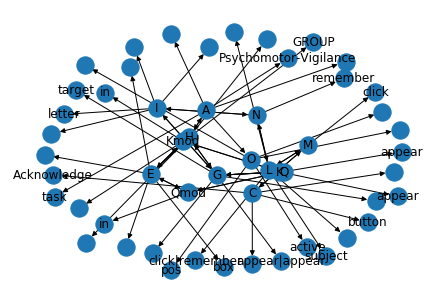

In [49]:
DRSToItem()